# NGC 1866: Age Determination

In [2]:
import numpy as np
import subprocess

from astropy.io import fits
from astropy.table import Table, Column, join
import astropy.units as u
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks
from scipy.spatial.distance import cdist

from ccdproc import CCDData, Combiner, subtract_overscan, trim_image, create_deviation

from photutils import DAOStarFinder, CircularAperture, aperture_photometry

from glob import glob
from itertools import product

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Loading data

- `phot_table`: The observation data
- `isochrone_table`: The isochrone models

For this analysis we will use the filters F438W (B) and F555W (V) to make B vs. B-V HR diagram.

In [3]:
phot_table = Table.read("../data/NGC1866_data_tables/ngc1866_cluster_stars1_corrected_final.short.dat",format='ascii')

In [12]:
isochrone_table = Table.read("../data/NGC1866_data_tables/isoc_z008_full_wfc3.dat",format='ascii')

### Plotting the observations

To get a sense of what they look like.

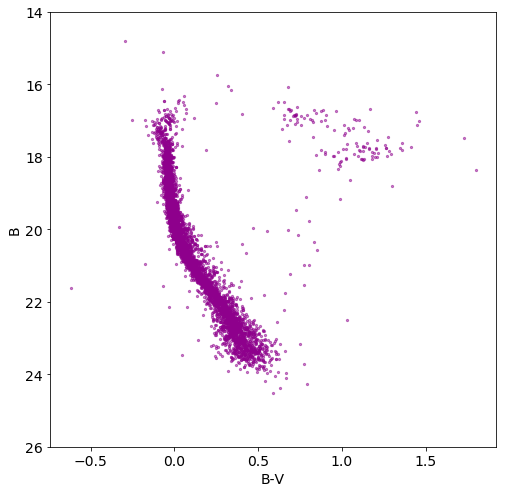

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=14)

# observations    
ax.scatter(phot_table["f438w"]-phot_table["f555w"], phot_table["f438w"], 
           marker='o', c='#8e008c', alpha=0.5, s=5, label="Observations")

ax.set_ylim(26,14)

ax.set_ylabel("B",size=14)
ax.set_xlabel("B-V",size=14)

fig.savefig("../doc/plots/obs_hst_phot.pdf")

plt.show()

### Plotting all the isochrones all at once
(Just for fun)

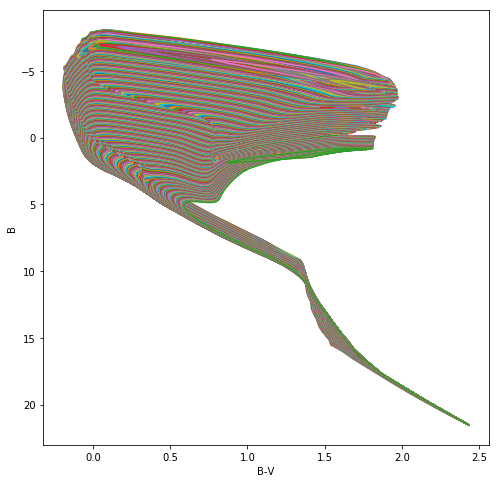

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

for age in np.unique(isochrone_table['log(age/yr)']):
    single_age = isochrone_table[isochrone_table['log(age/yr)']==age]
    ax.plot(single_age["F438W"]-single_age['F555W'],single_age["F438W"], '-')

ax.set_ylabel("B")
ax.set_xlabel("B-V")

ax.set_ylim(ax.get_ylim()[::-1])
        
plt.show()

## Fitting functions

The extinction coefficients for the filters of interest are:

    A_F555W = A_V
    A_F438W = 1.33*A_V
    
Given an extinction value (A_V) and distance modulus (DM) we calculate the apparent magnitudes for the models as:
    
    m_f438w = M_f438W + DM + A_V*1.33
    m_f555w = M_f555W + DM + A_V

I then determine the best fit age by calculating the mean square error for each isochrone model by finding the minimum distance between each observed point and the isochrone model, and then taking the mean square of those distances.  I minimize this value to determine the best log(age/year). 

In [18]:
def get_fit_err(model, observations):
    """
    Calculate the Mean Square Error for given model and observations.
    
    Parameters
    ----------
    model : array
        Model array, should be n x 2 dimensions, i.e. [[B_0,BV_0],[B_1,BV_1],[B_2,BV_2],...]
    observations : array
        Observations array, should be n x 2 dimensions, i.e. [[B_0,BV_0],[B_1,BV_1],[B_2,BV_2],...]
        
    Returns
    -------
    response : float
        The mean square error of the observations array assuming the model array contains the true values.
    """
    
    distance_arrays = cdist(observations, model)
    min_dists = distance_arrays.min(1)

    return (1/len(min_dists)) * sum(min_dists**2)

In [19]:
def fit_isochrone(isochrone_table, phot_table, distance_modulus, A_V):
    """
    Given distance_modulus and A_V values, find the best fit age for the photmetric data given.
    
    Parameters
    ----------
    isochrone_table : astropy.table.Table
        Table contianing isochrone models, must have columns with names: log(age/yr), F438W, F555W
    phot_table : astropy.table.Table
        Table containing the observation data, must have columns with names: f438w, f555w
        
    Returns
    -------
    response : tuple
        (best fit age, best fit age mean square error)
    """
    
    # Setting up the observed array
    observed_B_BV = list(zip(phot_table["f438w"], phot_table["f438w"]-phot_table["f555w"]))
    
    best_age = 0
    best_age_err = 100
    for age in np.unique(isochrone_table['log(age/yr)']):
        single_age = isochrone_table[isochrone_table['log(age/yr)'] == age]
        model_B_BV = list(zip(single_age["F438W"] + distance_modulus + (A_V*1.33), 
                              single_age["F438W"] - single_age['F555W']  + (A_V*0.33)))
        
        mean_sq_err = get_fit_err(model_B_BV, observed_B_BV)
        
        if mean_sq_err < best_age_err:
            best_age_err = mean_sq_err
            best_age = age
            
    return (best_age, best_age_err)
               

## Iterating over distance modulus and A_V

I calculate the best fit and mean square error for a grid of distance modulus and A_V value, and plot the result.

In [21]:
# Note: This step takes a while (on the order of half an hour?)

all_ages = []
all_age_errs = []
all_dist_mods = []
all_A_Vs = []

for dist_mod, A_V in product(np.linspace(15,25,21), np.linspace(0,1,21)):

    age, age_err = fit_isochrone(isochrone_table, phot_table, dist_mod, A_V)
    
    all_ages.append(age)
    all_age_errs.append(age_err)
    all_dist_mods.append(dist_mod)
    all_A_Vs.append(A_V)


In [162]:
age_fit_table = Table(names=["log(age/yr)","age fit error","distance modulus","A_V"],
                      data=[all_ages,all_age_errs,all_dist_mods,all_A_Vs])

#### Write/read the reults table

This calculation took a really long time, so this way I can just read it in rather than having to do the whole thing over.

In [22]:
#age_fit_table.write("../data/NGC1866_data_tables/age_fit_table.ecsv",format="ascii.ecsv")
age_fit_table = Table.read("../data/NGC1866_data_tables/age_fit_table.ecsv")

#### Collecting the best fit values

In [23]:
best_ind = np.argmin(age_fit_table["age fit error"])

dist_mod = age_fit_table["distance modulus"][best_ind]
A_V = age_fit_table["A_V"][best_ind]
age = age_fit_table["log(age/yr)"][best_ind]
age_err = age_fit_table["age fit error"][best_ind]

#### Plotting the error grid

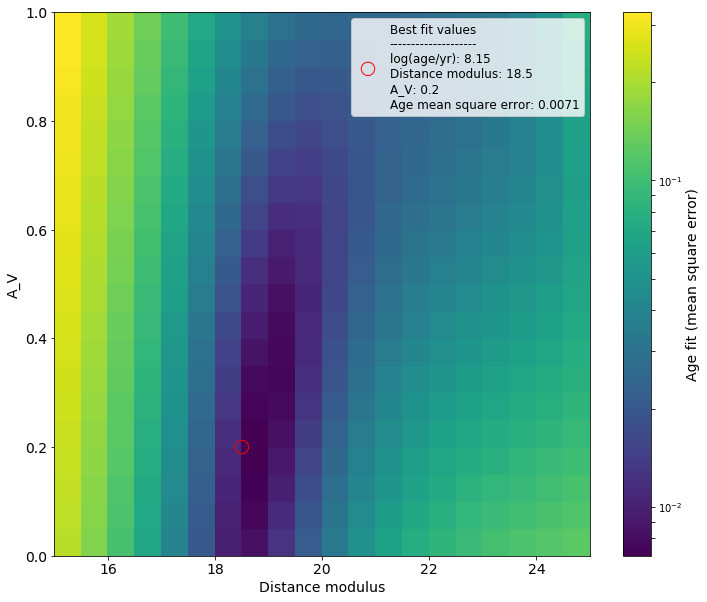

In [31]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=14)
   
im = ax.pcolormesh(age_fit_table["distance modulus"].reshape(21,21),
                   age_fit_table["A_V"].reshape(21,21),
                   age_fit_table["age fit error"].reshape(21,21),
                   cmap='viridis',norm=LogNorm())
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Age fit (mean square error)', size=14)

best_fit_ind = np.argmin(age_fit_table["age fit error"])
ax.scatter(dist_mod, A_V, marker='o', edgecolor='red', facecolor="None", s=180,
           label=f"Best fit values\n--------------------\nlog(age/yr): {age:.3}\nDistance modulus: {dist_mod:.4}\nA_V: {A_V:.3}\nAge mean square error: {age_err:.2}")

ax.legend(fontsize=12)
ax.set_xlabel("Distance modulus", size=14)
ax.set_ylabel("A_V", size=14)

plt.savefig("../doc/plots/age_fit.pdf")

plt.show()

#### Plotting the best fit isochron and observational data

<IPython.core.display.Javascript object>


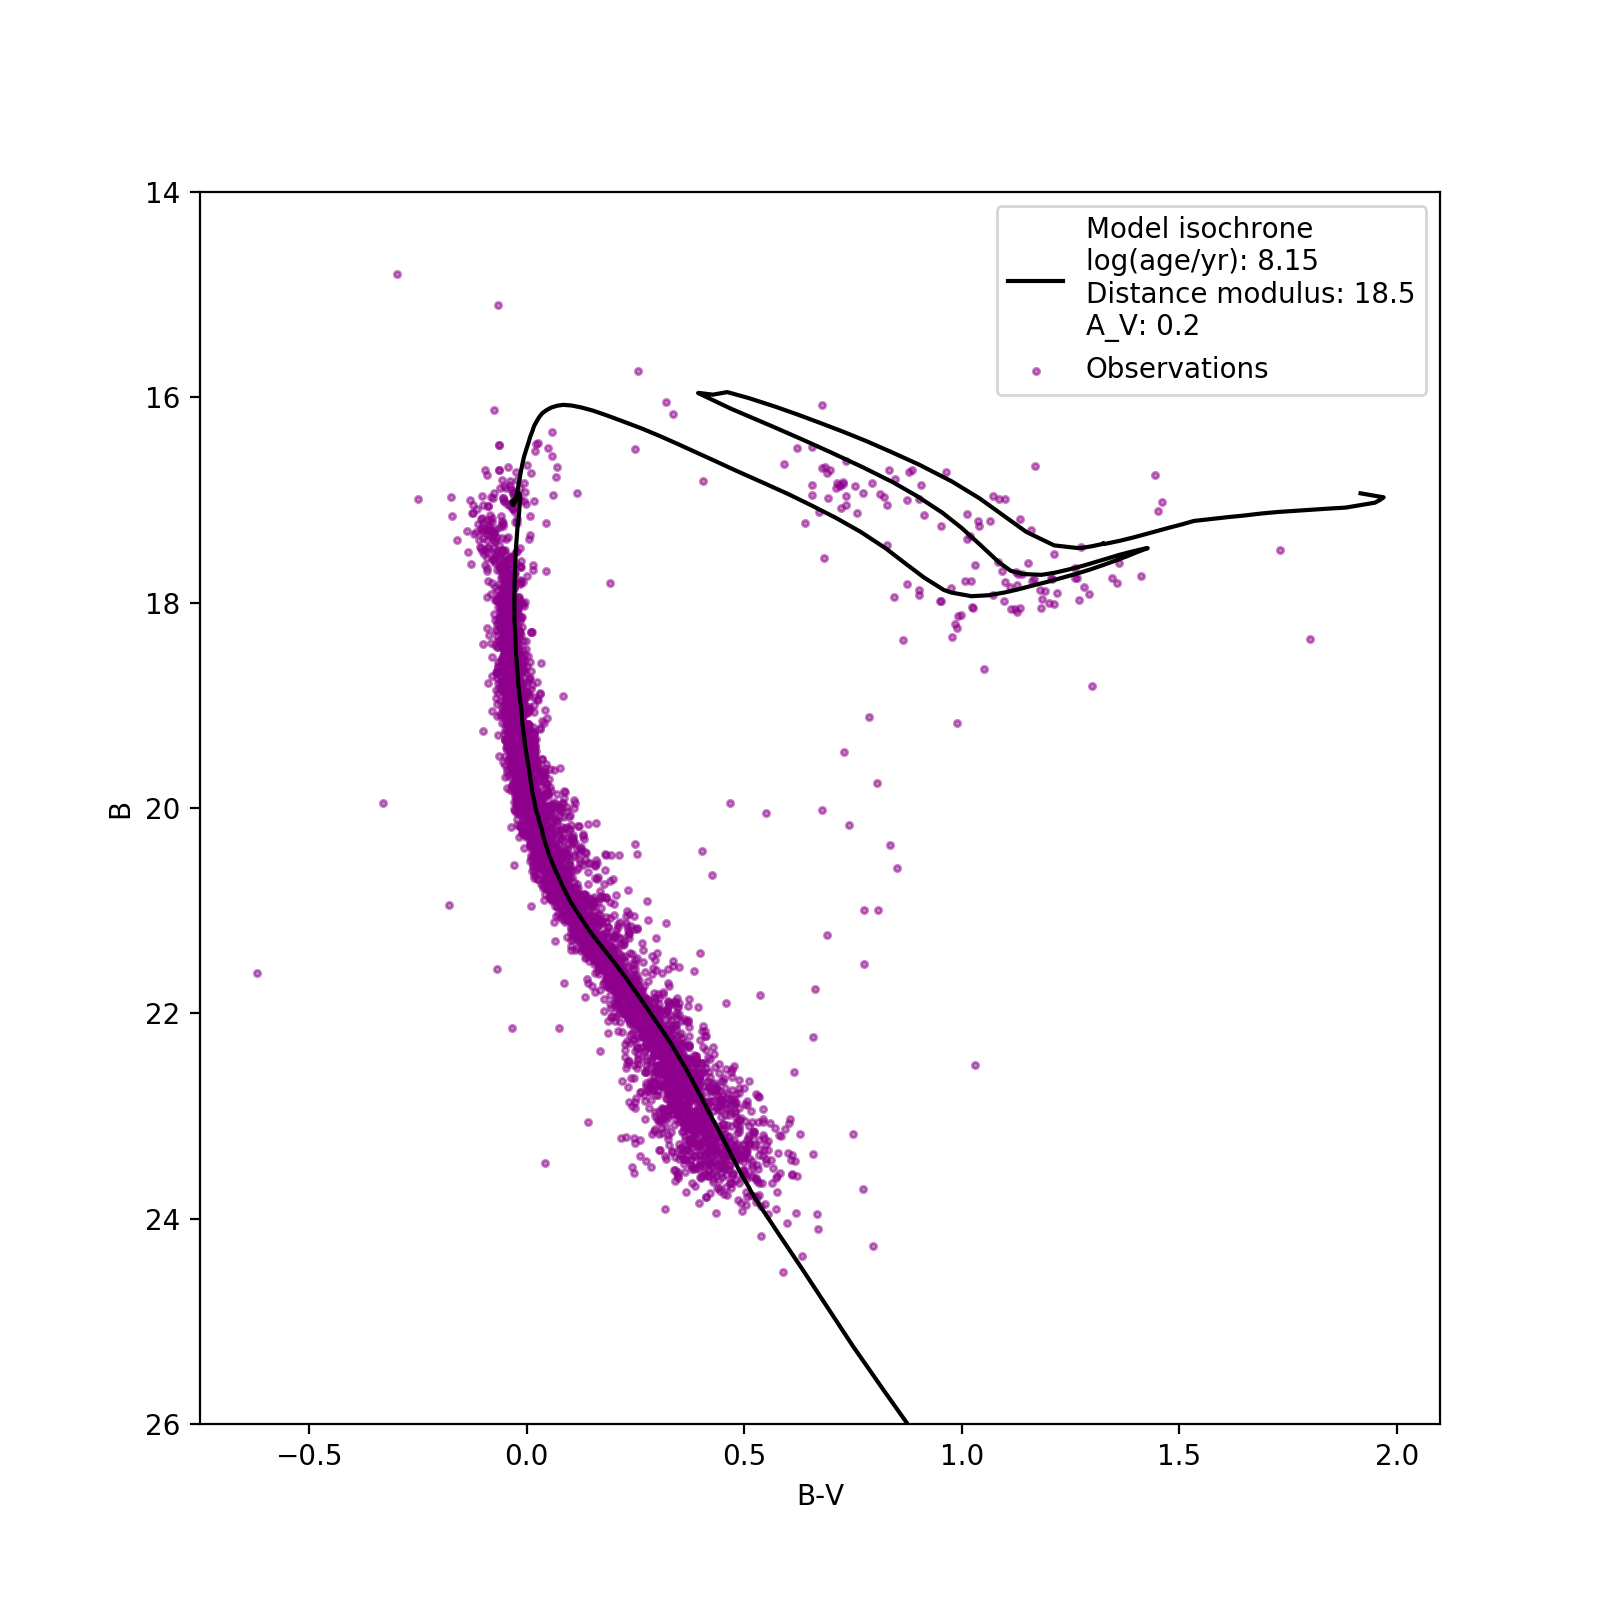

In [219]:
best_isochrone = isochrone_table[isochrone_table['log(age/yr)'] == age]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# observations    
ax.scatter(phot_table["f438w"]-phot_table["f555w"], phot_table["f438w"], 
           marker='o', c='#8e008c', alpha=0.5, s=5, label="Observations")

# isochrone 
ax.plot(best_isochrone["F438W"] - best_isochrone['F555W']  + (A_V*0.33),
        best_isochrone["F438W"] + dist_mod + (A_V*1.33), '-', color='black',
        label=f"Model isochrone\nlog(age/yr): {age:.3}\nDistance modulus: {dist_mod:.4}\nA_V: {A_V:.3}")

ax.set_ylim(26,14)

ax.legend()

ax.set_ylabel("B")
ax.set_xlabel("B-V")

plt.show()

### Trying to get a better fit 

Seeing if I can refine the values by doing a second iteration around the best fit value from the first iteration.

In [220]:
# Again this step takes time.

all_ages = []
all_age_errs = []
all_dist_mods = []
all_A_Vs = []

for dist_mod, A_V in product(np.linspace(18.2,18.8,11), np.linspace(.1,0.3,11)):

    age, age_err = fit_isochrone(isochrone_table, phot_table, dist_mod, A_V)
    
    all_ages.append(age)
    all_age_errs.append(age_err)
    all_dist_mods.append(dist_mod)
    all_A_Vs.append(A_V)

In [222]:
age_fit_table_zoom = Table(names=["log(age/yr)","age fit error","distance modulus","A_V"],
                           data=[all_ages,all_age_errs,all_dist_mods,all_A_Vs])

#### Write/read the results table

This one didn't take as long because I was running over fewer values, but it still took awhile.

In [35]:
#age_fit_table_zoom.write("../data/NGC1866_data_tables/age_fit_table_zoom.ecsv",format="ascii.ecsv")
age_fit_table_zoom = Table.read("../data/NGC1866_data_tables/age_fit_table_zoom.ecsv")

#### Collecting the best fit values

In [36]:
best_ind = np.argmin(age_fit_table_zoom["age fit error"])

dist_mod = age_fit_table_zoom["distance modulus"][best_ind]
A_V = age_fit_table_zoom["A_V"][best_ind]
age = age_fit_table_zoom["log(age/yr)"][best_ind]
age_err = age_fit_table_zoom["age fit error"][best_ind]

#### Plotting the error grid

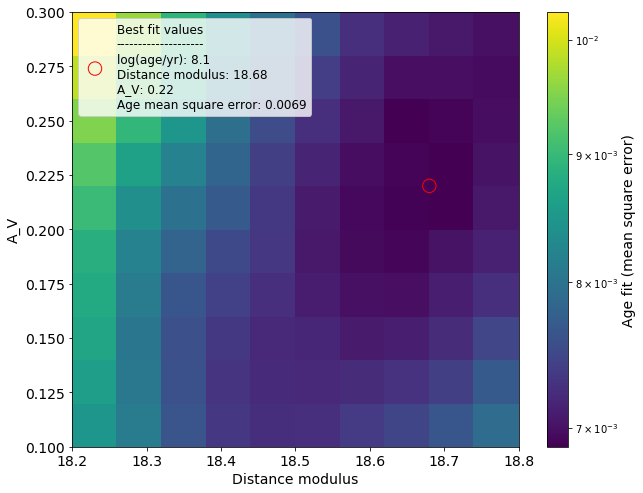

In [40]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=14)
   
im = ax.pcolormesh(age_fit_table_zoom["distance modulus"].reshape(11,11),
                   age_fit_table_zoom["A_V"].reshape(11,11),
                   age_fit_table_zoom["age fit error"].reshape(11,11),
                   cmap='viridis',norm=LogNorm())
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Age fit (mean square error)', size=14)

best_fit_ind = np.argmin(age_fit_table_zoom["age fit error"])
ax.scatter(dist_mod, A_V, marker='o', edgecolor='red', facecolor="None", s=180,
           label=f"Best fit values\n--------------------\nlog(age/yr): {age:.3}\nDistance modulus: {dist_mod:.4}\nA_V: {A_V:.3}\nAge mean square error: {age_err:.2}")

ax.legend(loc="upper left", fontsize=12)
ax.set_xlabel("Distance modulus", size=14)
ax.set_ylabel("A_V", size=14)

plt.savefig("../doc/plots/age_fit_zoom.pdf")

plt.show()

#### Plotting the best fit isochrone

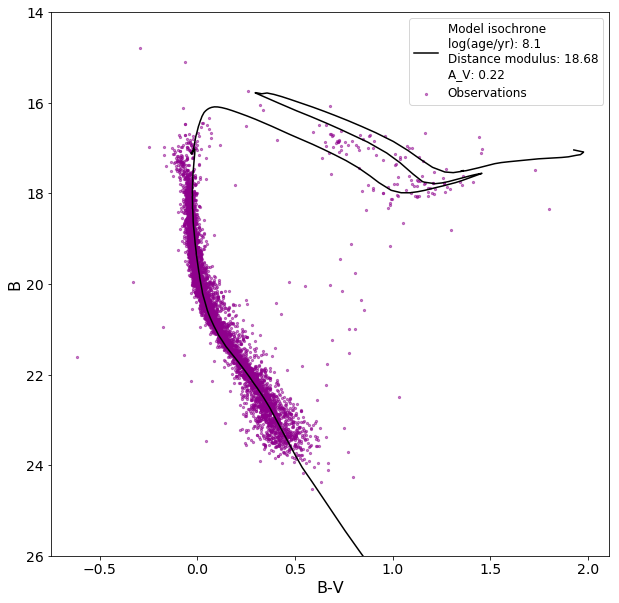

In [44]:
best_isochrone = isochrone_table[isochrone_table['log(age/yr)'] == age]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=14)

# observations    
ax.scatter(phot_table["f438w"]-phot_table["f555w"], phot_table["f438w"], 
           marker='o', c='#8e008c', alpha=0.5, s=5, label="Observations")

# isochrone 
ax.plot(best_isochrone["F438W"] - best_isochrone['F555W']  + (A_V*0.33),
        best_isochrone["F438W"] + dist_mod + (A_V*1.33), '-', color='black',
        label=f"Model isochrone\nlog(age/yr): {age:.3}\nDistance modulus: {dist_mod:.4}\nA_V: {A_V:.3}")

ax.set_ylim(26,14)

ax.legend(fontsize=12)

ax.set_ylabel("B", size=16)
ax.set_xlabel("B-V", size=16)

fig.savefig("../doc/plots/best_fit_isochrone.pdf")

plt.show()